In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
import pandas as pd

This is based on the [homework of week 5](https://github.com/rmcelreath/statrethinking_winter2019/blob/master/homework/week05.pdf) of Statistical Rethinking book material.
I do the homework based on the questions but not following a specific order.
<br>
<br>
The dataset can be found [here](https://github.com/rmcelreath/rethinking/tree/Experimental/data)
<br>

In [2]:
df = pd.read_csv('../data/Wines2012.csv', sep=';')
df.head()

,judge,flight,wine,score,wine.amer,judge.amer
0,Jean-M Cardebat,white,A1,10.0,1,0
1,Jean-M Cardebat,white,B1,13.0,1,0
2,Jean-M Cardebat,white,C1,14.0,0,0
3,Jean-M Cardebat,white,D1,15.0,0,0
4,Jean-M Cardebat,white,E1,8.0,1,0


In [39]:
df.describe()

,score,wine.amer,judge.amer,score_std
count,180.000000,180.000000,180.000000,1.800000e+02
mean,14.200000,0.600000,0.555556,2.627528e-16
std,2.663953,0.491264,0.498290,1.000000e+00
min,7.000000,0.000000,0.000000,-2.702750e+00
25%,12.000000,0.000000,0.000000,-8.258403e-01
50%,14.500000,1.000000,1.000000,1.126146e-01
75%,16.000000,1.000000,1.000000,6.756875e-01
max,19.500000,1.000000,1.000000,1.989524e+00


Standardizing score:

In [3]:
df['score_std'] = (df['score'] - df['score'].mean()) / df['score'].std()
df.score_std

0     -1.576604
1     -0.450458
2     -0.075076
3      0.300306
4     -2.327368
         ...   
175   -0.825840
176    0.300306
177    0.675687
178   -2.702750
179    1.051069
Name: score_std, Length: 180, dtype: float64

In [4]:
judge_cat = df['judge'].astype('category').cat.codes
wine_cat = df['wine'].astype('category').cat.codes

As the outcome **score** was standardized the priors we're chosen to be centered on 0 and having a standard deviation of 0.5.

In [23]:
SAMP_SIZE = 2000

with pm.Model() as m1:
    bJ = pm.Normal('bJ', 0, 0.5, shape=len(judge_cat.unique()))
    bW = pm.Normal('bW', 0, 0.5, shape=len(wine_cat.unique()))
    
    sigma = pm.Exponential('sigma', 1)
    mu = bJ[judge_cat] + bW[wine_cat]
    
    score_std = pm.Normal('score_std', mu=mu, sigma=sigma, observed=df['score_std'])
    
    m1_trace = pm.sample()
    
    # burned trace
    m1_trace = m1_trace[int(SAMP_SIZE/4):]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bW, bJ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/plots/traceplot.py:191: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (30), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'bJ\n0'}>,
        <AxesSubplot:title={'center':'bJ\n0'}>],
       [<AxesSubplot:title={'center':'bJ\n1'}>,
        <AxesSubplot:title={'center':'bJ\n1'}>],
       [<AxesSubplot:title={'center':'bJ\n2'}>,
        <AxesSubplot:title={'center':'bJ\n2'}>],
       [<AxesSubplot:title={'center':'bJ\n3'}>,
        <AxesSubplot:title={'center':'bJ\n3'}>],
       [<AxesSubplot:title={'center':'bJ\n4'}>,
        <AxesSubplot:title={'center':'bJ\n4'}>],
       [<AxesSubplot:title={'center':'bJ\n5'}>,
        <AxesSubplot:title={'center':'bJ\n5'}>],
       [<AxesSubplot:title={'center':'bJ\n6'}>,
        <AxesSubplot:title={'center':'bJ\n6'}>],
       [<AxesSubplot:title={'center':'bJ\n7'}>,
        <AxesSubplot:title={'center':'bJ\n7'}>],
       [<AxesSubplot:title={'center':'bJ\n8'}>,
        <AxesSubplot:title={'center':'bJ\n8'}>],
       [<AxesSubplot:title={'center':'bW\n0'}>,
        <AxesSubplot:title={'center':'bW\n0'}>],
       [<AxesSubplot:title={'c

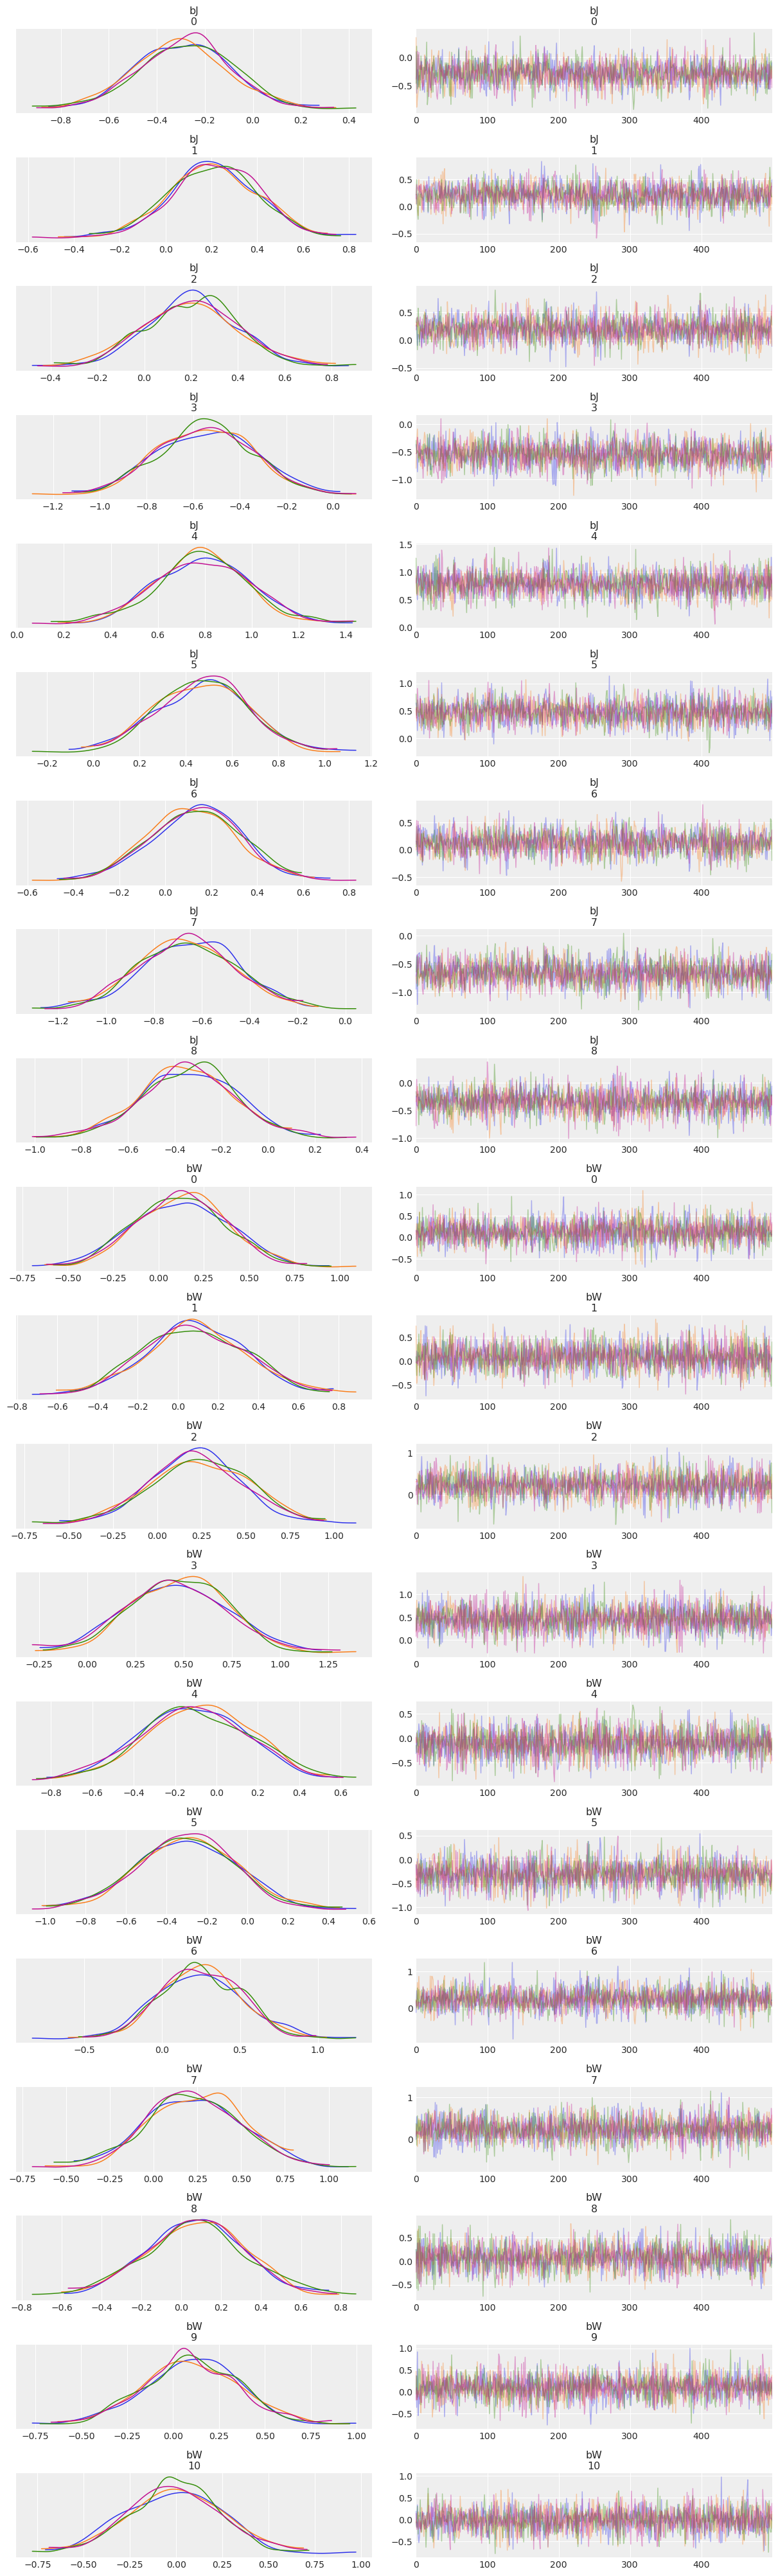

In [24]:
az.plot_trace(m1_trace)

All chains seem healthy as they all look like "hairy caterpillars". A more formal definition according to the book is: 

*Now, how is this chain a healthy one? Typically we look for three things in these trace plots: (1) stationarity, (2) good mixing, and (3) convergence. Stationarity refers to the path of each chain staying within the same high-probability portion of the posterior distribution. Notice that these traces, for example, all stick around a very stable central tendency, the center of gravity of each dimension of the posterior. Another way to think of this is that the mean value of the chain is quite stable from beginning to end. Good mixing means that the chain rapidly explores the full region. It doesn’t slowly wander, but rather rapidly zig-zags around, as a good Hamiltonian chain should. Convergence means that multiple, independent chains stick around the same region of high probability.*

In [25]:
az.summary(m1_trace, credible_interval=.89, round_to=2)

/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/utils.py:660: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  warnings.warn(
/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bJ[0],-0.29,0.20,-0.65,0.10,0.0,0.00,2520.35,1896.14,2507.08,1648.23,1.0
bJ[1],0.21,0.19,-0.14,0.57,0.0,0.00,2344.55,1704.16,2345.19,1529.75,1.0
bJ[2],0.20,0.20,-0.19,0.56,0.0,0.00,2487.27,1657.91,2499.15,1549.63,1.0
bJ[3],-0.55,0.21,-0.92,-0.16,0.0,0.00,2499.18,1938.11,2511.17,1332.65,1.0
bJ[4],0.79,0.20,0.40,1.15,0.0,0.00,2535.23,2535.23,2553.75,1530.05,1.0
bJ[5],0.47,0.20,0.11,0.83,0.0,0.00,2516.07,2375.69,2538.13,1743.89,1.0
bJ[6],0.13,0.19,-0.23,0.50,0.0,0.00,2074.96,1585.20,2077.23,1559.03,1.0
bJ[7],-0.66,0.20,-1.04,-0.28,0.0,0.00,2495.99,2315.46,2495.14,1625.41,1.0
bJ[8],-0.34,0.20,-0.74,0.02,0.0,0.00,2402.40,1961.47,2412.50,1828.76,1.0
bW[0],0.13,0.25,-0.36,0.56,0.0,0.01,2896.53,1056.53,2950.75,1562.23,1.0


/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

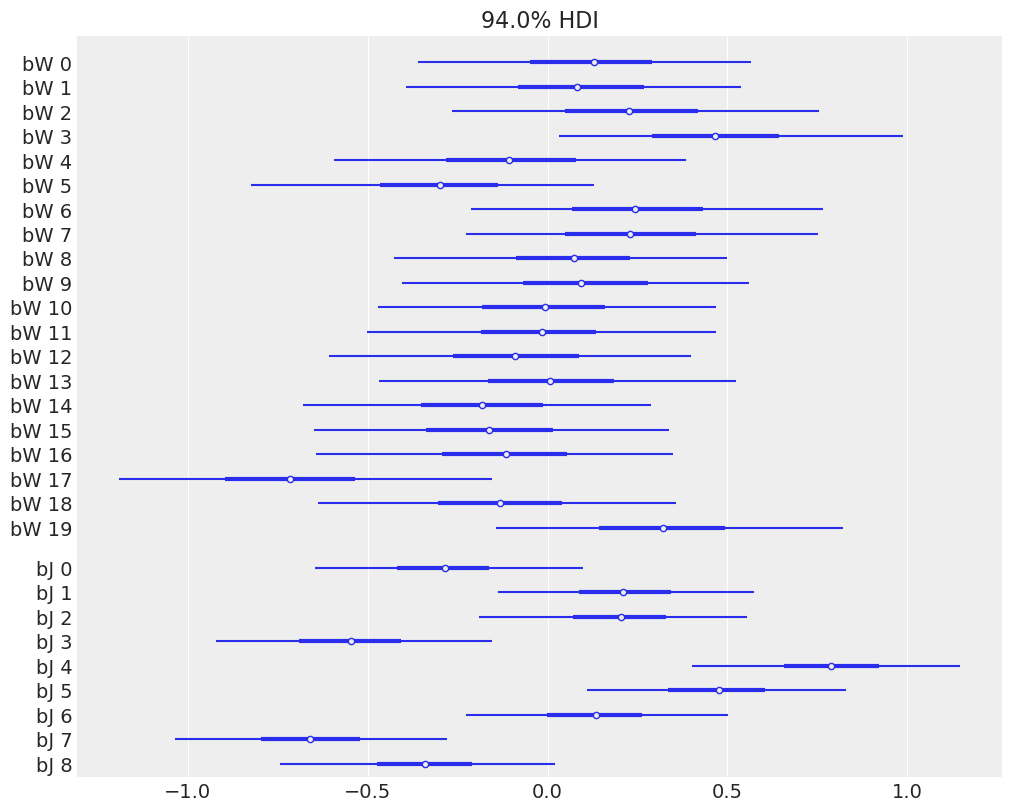

In [26]:
az.style.use("arviz-darkgrid")
az.plot_forest([m1_trace], 
              var_names=["bW", "bJ"],
              combined=True,
              figsize=[10,8])

The results show how much each judge and wine influence the scores. So for judges we can identify which ones give lowest and highest scores to wines. 
Judge 4 liked more the wines as, overall, he/she tends to give higher scores to them. On the other side judge 7 liked the least the wines.
<br>
And for wines we can tell which ones are better evaluated by judges. In this dataset the wine judges liked the most is the one of index 3 and the wine that judges liked the least is clearly the wine index 17.
<br>

---

In [90]:
print('Flight unique values:', df['flight'].unique())
print('American judges unique values:', df['judge.amer'].unique())
print('American wines unique values:', df['wine.amer'].unique())

Flight unique values: ['white' 'red']
American judges unique values: [0 1]
American wines unique values: [1 0]


In [91]:
flight_cat = df['flight'].astype('category').cat.codes

# check how it categorized the values
dict(enumerate(df.flight.astype('category').cat.categories))

{0: 'red', 1: 'white'}

In [86]:
SAMP_SIZE = 2000

with pm.Model() as m2:
    bF = pm.Normal('bF', 0, 0.5, shape=len(df['flight'].unique()))
    bWA = pm.Normal('bWA', 0, 0.5, shape=len(df['wine.amer'].unique()))
    bJA = pm.Normal('bJA', 0, 0.5, shape=len(df['judge.amer'].unique()))
    
    sigma = pm.Exponential('sigma', 1)
    
    mu = bF[flight_cat] + bWA[df['wine.amer']] + bJA[df['judge.amer']]
    
    score_std = pm.Normal('score_std', mu=mu, sigma=sigma, observed=df['score_std'])
    
    m2_trace = pm.sample()
    
    # burned trace
    m2_trace = m2_trace[int(SAMP_SIZE/4):]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bJA, bWA, bF]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'bF\n0'}>,
        <AxesSubplot:title={'center':'bF\n0'}>],
       [<AxesSubplot:title={'center':'bF\n1'}>,
        <AxesSubplot:title={'center':'bF\n1'}>],
       [<AxesSubplot:title={'center':'bWA\n0'}>,
        <AxesSubplot:title={'center':'bWA\n0'}>],
       [<AxesSubplot:title={'center':'bWA\n1'}>,
        <AxesSubplot:title={'center':'bWA\n1'}>],
       [<AxesSubplot:title={'center':'bJA\n0'}>,
        <AxesSubplot:title={'center':'bJA\n0'}>],
       [<AxesSubplot:title={'center':'bJA\n1'}>,
        <AxesSubplot:title={'center':'bJA\n1'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

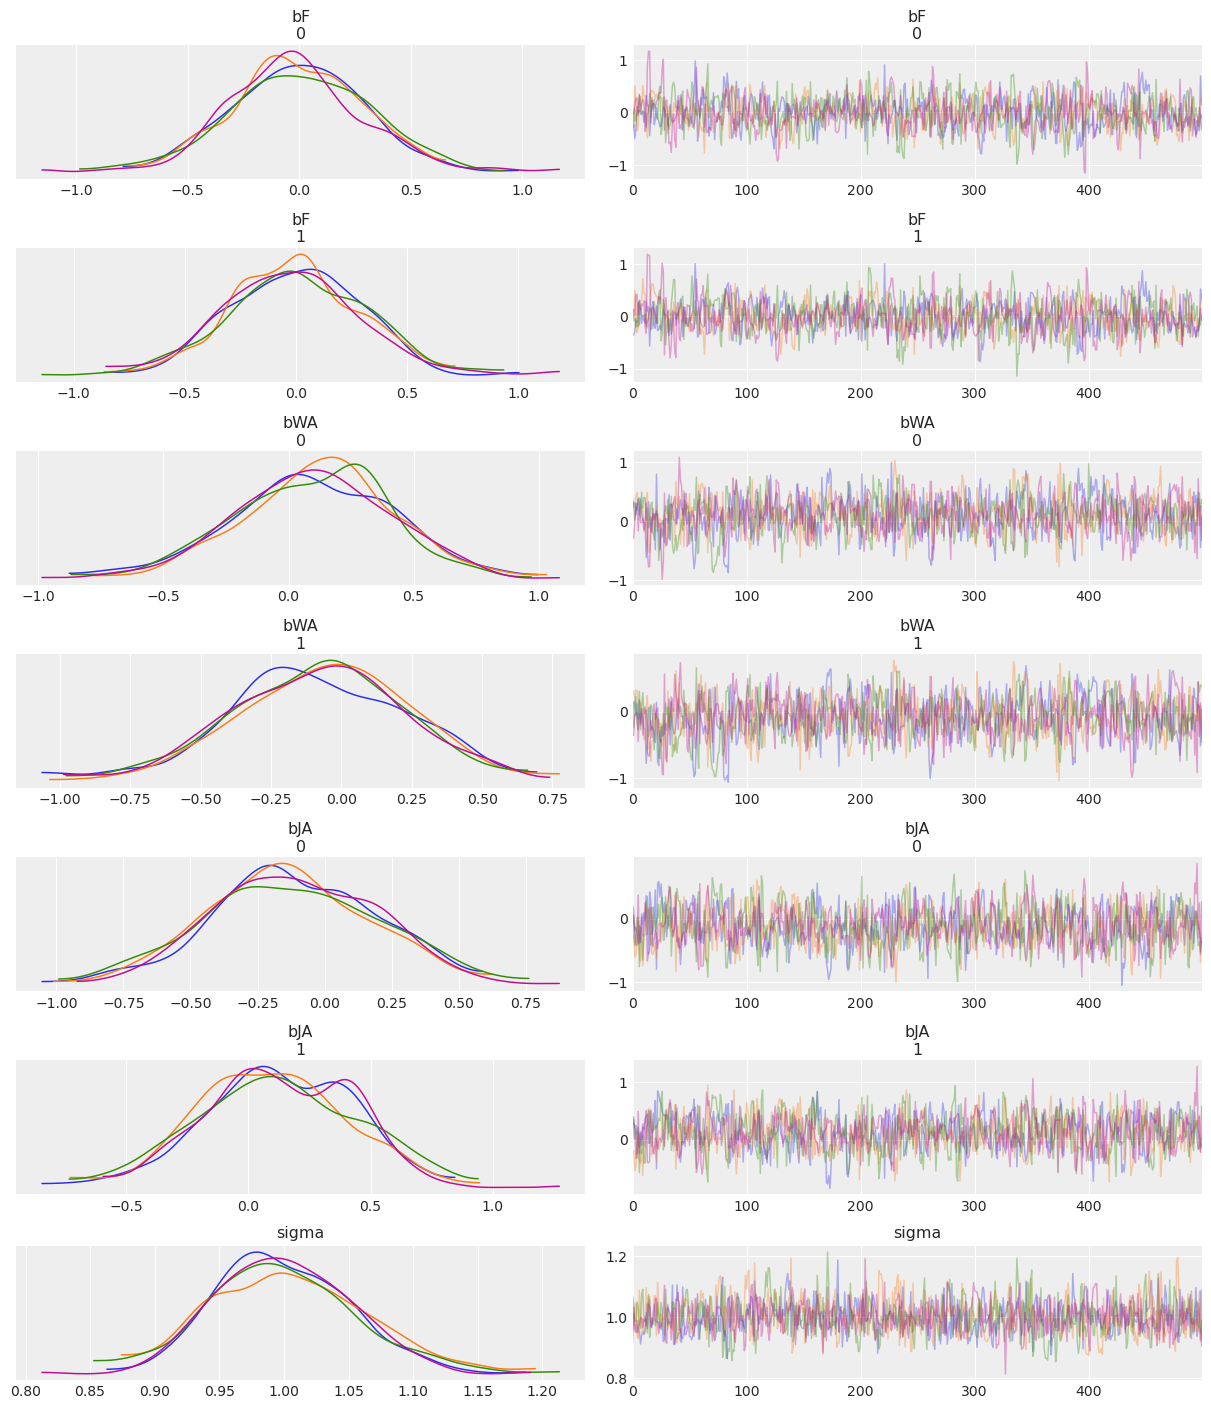

In [57]:
az.plot_trace(m2_trace)

All chains seem healthy as they all look like "hairy caterpillars".

In [46]:
az.summary(m2_trace, credible_interval=.89, round_to=2)

/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/utils.py:660: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  warnings.warn(
/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bF[0],-0.01,0.30,-0.54,0.58,0.01,0.01,939.29,799.65,937.05,1056.95,1.0
bF[1],-0.00,0.31,-0.58,0.53,0.01,0.01,928.55,787.30,930.15,894.79,1.0
bWA[0],0.10,0.31,-0.49,0.68,0.01,0.01,894.98,845.77,899.78,975.86,1.0
bWA[1],-0.08,0.31,-0.62,0.54,0.01,0.01,897.50,721.57,904.28,889.37,1.0
bJA[0],-0.12,0.31,-0.66,0.48,0.01,0.01,1048.69,983.91,1042.71,1119.53,1.0
bJA[1],0.12,0.31,-0.43,0.69,0.01,0.01,973.01,774.76,975.02,992.95,1.0
sigma,1.00,0.06,0.91,1.11,0.00,0.00,1317.45,1317.45,1311.98,794.09,1.0


There's no difference between red and white wines.<br>
American wines have slightly lower average scores than non-americans.<br>
American judges slightly tend give better scores to the wines than non-americans. 